Welcome to our Pet Breed classifier:


In [1]:
from fastai.vision.all import *
from pathlib import Path

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [2]:
ds_path = Path('/kaggle/input/the-oxfordiiit-pet-dataset/images')
ds_path.ls()

(#7394) [Path('/kaggle/input/the-oxfordiiit-pet-dataset/images/american_pit_bull_terrier_16.jpg'),Path('/kaggle/input/the-oxfordiiit-pet-dataset/images/leonberger_200.jpg'),Path('/kaggle/input/the-oxfordiiit-pet-dataset/images/english_cocker_spaniel_35.jpg'),Path('/kaggle/input/the-oxfordiiit-pet-dataset/images/Siamese_67.jpg'),Path('/kaggle/input/the-oxfordiiit-pet-dataset/images/boxer_77.jpg'),Path('/kaggle/input/the-oxfordiiit-pet-dataset/images/saint_bernard_146.jpg'),Path('/kaggle/input/the-oxfordiiit-pet-dataset/images/american_bulldog_37.jpg'),Path('/kaggle/input/the-oxfordiiit-pet-dataset/images/Sphynx_239.jpg'),Path('/kaggle/input/the-oxfordiiit-pet-dataset/images/Egyptian_Mau_164.jpg'),Path('/kaggle/input/the-oxfordiiit-pet-dataset/images/Birman_116.jpg'),Path('/kaggle/input/the-oxfordiiit-pet-dataset/images/english_setter_178.jpg'),Path('/kaggle/input/the-oxfordiiit-pet-dataset/images/Siamese_110.jpg'),Path('/kaggle/input/the-oxfordiiit-pet-dataset/images/newfoundland_39.jpg

In [3]:
BATCH_SIZE=64
VERSION=1
ARCH='resnet101'
IMAGE_SIZE=224
NUM_EPOCHS=15

In [4]:
def breed_labeller(file_name):
    stem = Path(file_name).stem
    breed, *_ = stem.rsplit('_', 1)
    return breed.replace('_', ' ')


for file in ds_path.ls()[:3]:
    print(breed_labeller(file.name)) 

american pit bull terrier
leonberger
english cocker spaniel


In [5]:
def get_dls(batch_size, image_size):
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                       get_items=get_image_files,
                       get_y=breed_labeller,
                       splitter=RandomSplitter(valid_pct=0.2, seed=42),
                       item_tfms=Resize(224),
                       batch_tfms=[*aug_transforms(size=image_size, min_scale=0.75),
                                  Normalize.from_stats(*imagenet_stats)])
    return dblock.dataloaders(ds_path, bs=batch_size)

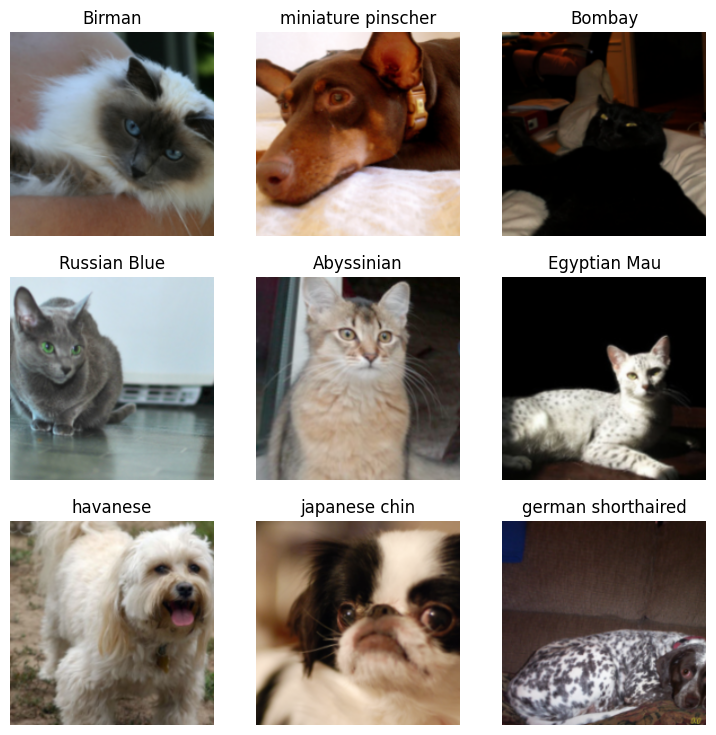

In [6]:
dls = get_dls(BATCH_SIZE, IMAGE_SIZE)

dls.show_batch()

In [7]:
learn = vision_learner(dls, resnet101, metrics=accuracy, loss_func=CrossEntropyLossFlat(label_smoothing=0.1))

learn.freeze()

learn.fit_one_cycle(1, lr_max=1e-3)

Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to /root/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth
100%|██████████| 171M/171M [00:00<00:00, 195MB/s]  


epoch,train_loss,valid_loss,accuracy,time
0,1.503851,1.100194,0.903215,02:54


SuggestedLRs(valley=3.0199516913853586e-05)

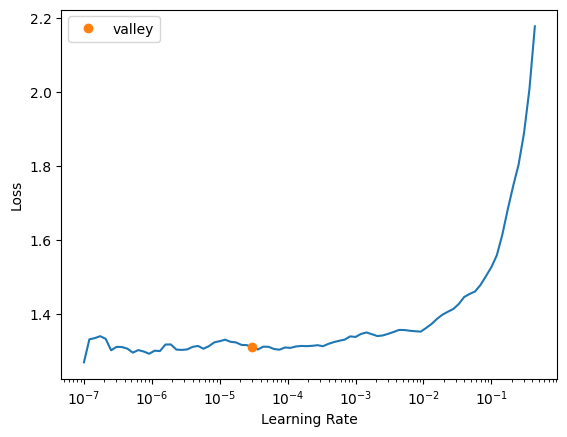

In [8]:
lr = learn.lr_find()
lr

In [9]:
LEARNING_RATE = lr.valley
LEARNING_RATE

3.0199516913853586e-05

In [10]:
learn.unfreeze()
learn.fit_one_cycle(NUM_EPOCHS, lr_max=slice(1e-5, LEARNING_RATE), cbs=[
    EarlyStoppingCallback(monitor='accuracy', patience=3),
    SaveModelCallback(monitor='accuracy', fname='best_pet_model')
])

epoch,train_loss,valid_loss,accuracy,time
0,1.318931,1.098821,0.903892,04:07
1,1.285013,1.057266,0.917090,04:07
2,1.225637,1.024028,0.935702,04:08
3,1.177640,0.971224,0.950931,04:08
4,1.127912,0.947131,0.956007,04:08
5,1.085933,0.921266,0.963452,04:07
6,1.051816,0.904488,0.971574,04:08
7,1.023547,0.884112,0.973942,04:08
8,1.004198,0.878819,0.975635,04:07
9,0.979971,0.875153,0.978342,04:08


Better model found at epoch 0 with accuracy value: 0.9038916826248169.
Better model found at epoch 1 with accuracy value: 0.9170897006988525.
Better model found at epoch 2 with accuracy value: 0.9357022047042847.
Better model found at epoch 3 with accuracy value: 0.950930655002594.
Better model found at epoch 4 with accuracy value: 0.9560067653656006.
Better model found at epoch 5 with accuracy value: 0.9634518027305603.
Better model found at epoch 6 with accuracy value: 0.9715735912322998.
Better model found at epoch 7 with accuracy value: 0.9739424586296082.
Better model found at epoch 8 with accuracy value: 0.9756345152854919.
Better model found at epoch 9 with accuracy value: 0.978341817855835.
Better model found at epoch 10 with accuracy value: 0.9796954393386841.
Better model found at epoch 11 with accuracy value: 0.980033814907074.
Better model found at epoch 12 with accuracy value: 0.9813874959945679.
Better model found at epoch 13 with accuracy value: 0.982741117477417.


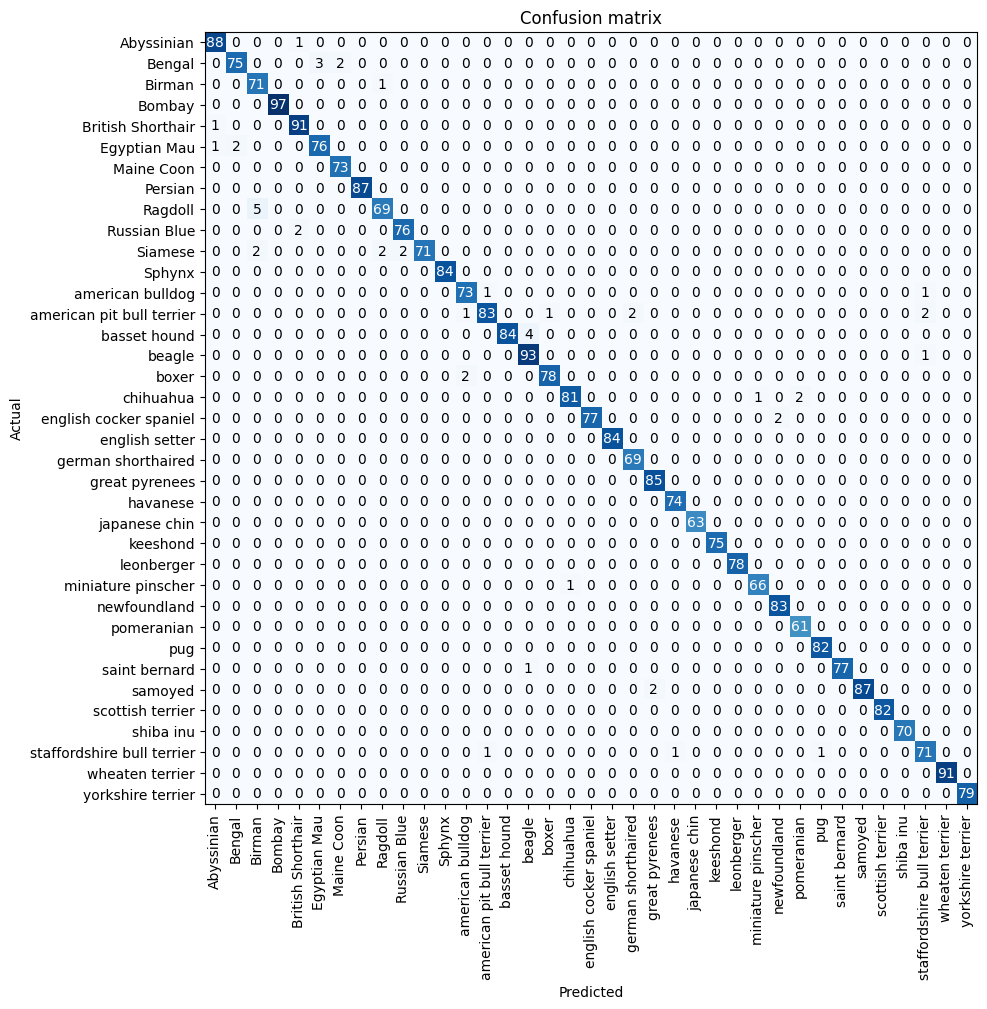

In [11]:
interp = ClassificationInterpretation.from_learner(learn, dl=dls.valid)
interp.plot_confusion_matrix(figsize=(10,10))

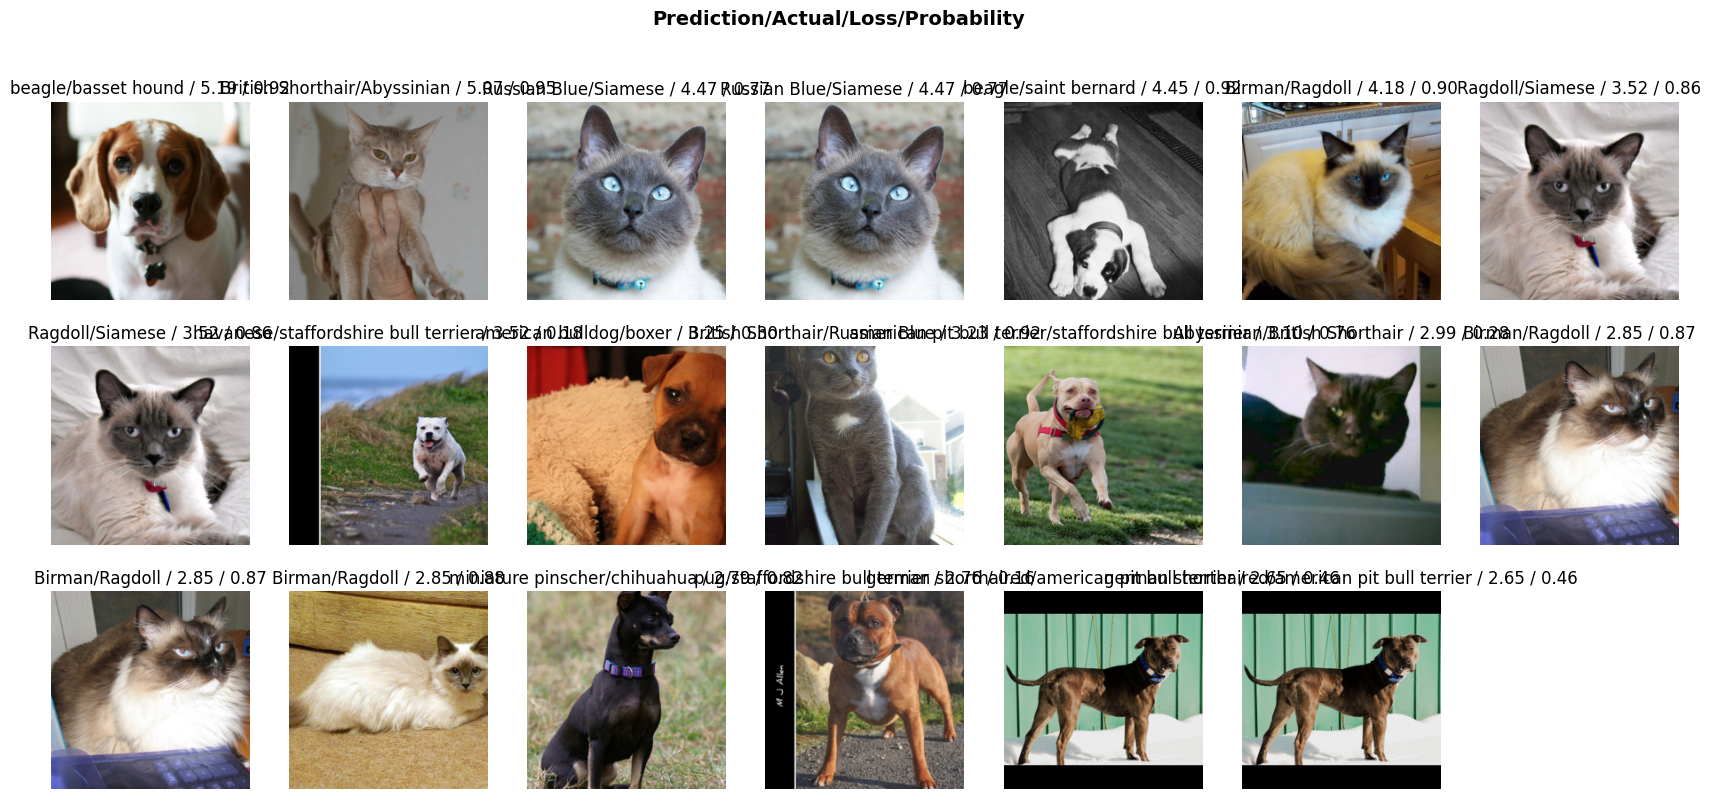

In [12]:
interp.plot_top_losses(20, nrows=3)

In [13]:
from datetime import datetime
ts = datetime.now().strftime("%Y%m%d-%H%M")

learn.export(f'pet_classifier_v{VERSION}_{ts}.pkl')


In [14]:
import json

metrics = {
    'version': f"v{VERSION}",
    'accuracy': learn.validate()[1],
    'architecture': ARCH,
    'image_size': IMAGE_SIZE,
    'timestamp': ts
}

with open(f'pet_classifier_v{VERSION}_{ts}.json', 'w') as f: json.dump(metrics, f, indent=4)


In [15]:
VERSION+=1